<a href="https://colab.research.google.com/github/Benned-H/Summer2019/blob/master/Simple_Reinforcement_Learning_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 0: Q-Learning with Tables and Neural Networks [[Link]](https://medium.com/emergent-future/simple-reinforcement-learning-with-tensorflow-part-0-q-learning-with-tables-and-neural-networks-d195264329d0)

We begin with a simpler algorithm than we'll see in the next few tutorials. **Policy gradients** attempt to learn functions which map observations to actions, whereas **Q-Learning** attempts to learn the value of being in a given state, and taking an action there. Even DeepQ networks are just larger and more complex versions of the algorithm we'll discuss here.

We'll be working in the [FrozenLake](https://gym.openai.com/envs/FrozenLake-v0/) environment from OpenAI Gym. This environment is a 4x4 grid of blocks, with blocks being one of the start block, goal block, a safe block, or dangerous hole. We want our agent to navigate to the goal without falling down a hole, but the ice is slippery and we might not move exactly as the agent attempts to.

In [1]:
# Import Gym, create and view environment
import gym
env = gym.make('FrozenLake-v0')
env.render()


SFFF
FHFH
FFFH
HFFG


In [2]:
# View actions/observations
print(env.action_space)
print(env.observation_space)

Discrete(4)
Discrete(16)


Discrete spaces allow a fixed range of non-negative numbers. Thus we have 4 possible actions, 0 to 3, and 16 possible observations for which of the 16 squares our agent is on.

In [31]:
# Note: The environment isn't randomized.
# It's the same each time.
env.reset()
env.render()


SFFF
FHFH
FFFH
HFFG


Our reward at every step is 0, except when we enter the goal, where we receive a reward of 1. This means we need an algorithm that can learn with long-term expected rewards, which Q-Learning can. The simplest implementation of Q-Learning is a table of values for each state (row) and action (column) possible. We learn a value for how good it is to take a given action within a given state for each combination. First, initialize all $16\times4=64$ cells to 0.

To update our table, we'll use the Bellman equation. This states that "the expected long-term reward for a given action is equal to the immediate reward from the current action combined with the expected reward from the best future action taken at the following state." Put differently (in my words), we want to figure out how valuable some choice is in the future. We can break this question into two parts:
1. How valuable is this decision immediately? This is easy to answer, because we immediately see the next step following our decision.
2. How valuable is the best choice we can then make? We've now recursively broken the question down into a simpler problem.

This approach allows us to reuse the Q-table when estimating how to update the table for some current decision. Formally, we could write:

$Q(s,a)=r + \gamma(\text{max}\{Q(s',a')\})$, where the Q-value for some given state $s$ and action $a$ is the current reward $r$ plus the maximum discounted reward $\gamma$ according the the next state $s'$ our decision results in. The discount function $\gamma$ allows us to vary how important possible future rewards are compared to the present reward. Thus we slowly develop an accurate table of expected rewards for given actions in given states.

From [A Beginner's Guide to Deep Reinforcement Learning](https://skymind.ai/wiki/deep-reinforcement-learning#define):

We multiply future rewards by a **discount factor** in order to lessen the impact they have on present decisions. This makes future rewards worth less than present rewards, but the gamma $\gamma$ parameter lets us pick exactly how much. As an example, with $\gamma=0.8$, and a reward of 10 in 3 time steps, the present value of the reward is $0.8^3*10$. A gamma of 1 thus treats future rewards as just as valuable as immediate rewards.

In [0]:
import random

def discount(arr, gamma):
  """ Discounts a given list of rewards using the given gamma.
      Gives the same results as an example from a workshop, so I trust my code here. """
  
  for r in range(len(arr)): # Loop over all rewards
    for i in range(r + 1, len(arr)): # For all future rewards...
      arr[r] += gamma ** (i-r) * arr[i] # Add discounted future rewards
    
  return arr

In [59]:
discount([1,2,3,1,2,3,50], 0.56)

[5.140374425600002,
 7.393525760000001,
 9.631296000000003,
 11.841600000000003,
 19.360000000000003,
 31.000000000000004,
 50]

At this point, I'll attempt to code this out myself:

In [0]:
def max_col_in_row(row):
  """ Returns one of the columns with the max value in a given numpy row. """
  maximum = np.amax(row) # Find the maximum value in the row.
  winners = []
  
  for c in range(len(row)):
    if (row[c] == maximum):
      winners.append(c) # Create list of columns containing the maximum value.
  
  return random.sample(winners, 1)[0]

def act(Q_table, obs):
  """ Chooses an action given an observation and our Q-table. """
  row = Q_table[obs] # Choose the maximum column for this state
  return max_col_in_row(row) # This will be the action yielding the highest expected reward.

def learn(Q_t, s, a, new_obs, r, lr, g):
  """ Learn based on action <a> we took in given state <s>. """
  max_exp = np.amax(Q_t[new_obs]) # Find the maximum reward we can expect in the future.
  delta = r + (g * max_exp) - Q_t[s][a] # Change the reward by this much.
  Q_t[s][a] += lr * delta
  
  return Q_t

In [0]:
# Q-Table Implementation on OpenAI Gym FrozenLake

import numpy as np

episodes = 2000 # Number of episodes to train for.
timesteps = 1000 # Cut the agent off after this many timesteps.
gamma = 0.95
learning_rate = 0.8 # Avoid overcommitting to any one lesson.

Q_table = np.zeros((env.observation_space.n, env.action_space.n)) # States by possible actions, 16 x 4.

records = [] # To store our scores over all episodes.

for ep in range(episodes):
  obs = env.reset() # Gets the current state we start in, which is 0.
  
  for t in range(timesteps):
    action = act(Q_table, obs) # Get our action.

    new_obs, reward, done, info = env.step(action) # Try our action in the environment.
    
    Q_table = learn(Q_table, obs, action, new_obs, reward, learning_rate, gamma) # Learn from what we did.
    
    obs = new_obs
    
    if done:
      records.append(reward) # Record if we won.
      break

### Debugging time

In [253]:
Q_table = np.zeros((env.observation_space.n, env.action_space.n)) # States by possible actions, 16 x 4.
Q_table[0][0] = 1
Q_table[0][1] = 2
Q_table[1][0] = 3
Q_table[1][2] = 3
print(Q_table)

[[1. 2. 0. 0.]
 [3. 0. 3. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [287]:
# The act method seems to work as intended.
act(Q_table, 1)

0

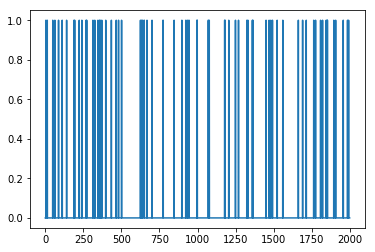

In [243]:
from matplotlib import pyplot as plt
plt.plot(records)

In [137]:
env.render()

  (Right)
SFFF
FHFH
FFFH
HFFG


These were helpful:
* Gym Discrete Space code [here](https://github.com/openai/gym/blob/master/gym/spaces/discrete.py)
* For [sampling a list](https://www.geeksforgeeks.org/python-random-sample-function/)

In [62]:
env.action_space.n

4

In [0]:
# Close the FrozenLake environment.
env.close()